[INFO] loading image...
[INFO] loading pre-trained ResNet50 model...
[INFO] generating perturbation...
step: 0, loss: -2.584144115447998...
step: 5, loss: -5.0830302238464355...
step: 10, loss: -7.851126670837402...
step: 15, loss: -11.533044815063477...
step: 20, loss: -15.439647674560547...
step: 25, loss: -19.368999481201172...
step: 30, loss: -23.64342498779297...
step: 35, loss: -28.75153350830078...
step: 40, loss: -34.696434020996094...
step: 45, loss: -40.662506103515625...
[INFO] creating adversarial example...
[INFO] running inference on the adversarial example...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[INFO] label: chainlink_fence confidence: 100.00%


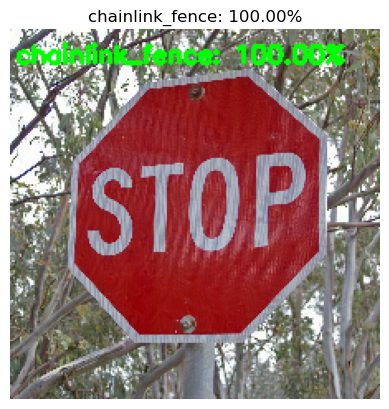

[INFO] Adversarial image created. Click the link below to download.


C:\Users\lfemu\Downloads\adversarial_STOP_sign.jpg

In [1]:
# Import necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import cv2
import os
from IPython.display import display, FileLink
from matplotlib import pyplot as plt

def preprocess_image(image):
    # Swap color channels, resize the input image, and add a batch dimension
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    # Return the preprocessed image
    return image

def clip_eps(tensor, eps):
    # Clip the values of the tensor to a given range and return it
    return tf.clip_by_value(tensor, clip_value_min=-eps, clip_value_max=eps)

def generate_adversaries(model, baseImage, delta, classIdx, steps=50):
    # Iterate over the number of steps
    for step in range(0, steps):
        # Record our gradients
        with tf.GradientTape() as tape:
            # Explicitly indicate that our perturbation vector should be tracked for gradient updates
            tape.watch(delta)

            # Add our perturbation vector to the base image and preprocess the resulting image
            adversary = preprocess_input(baseImage + delta)
            # Run this newly constructed image tensor through our model and calculate the loss with respect to the original class index
            predictions = model(adversary, training=False)
            loss = -sccLoss(tf.convert_to_tensor([classIdx]), predictions)
            # Check to see if we are logging the loss value, and if so, display it to our terminal
            if step % 5 == 0:
                print("step: {}, loss: {}...".format(step, loss.numpy()))
        
        # Calculate the gradients of loss with respect to the perturbation vector
        gradients = tape.gradient(loss, delta)
        # Update the weights, clip the perturbation vector, and update its value
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta, eps=EPS))
    
    # Return the perturbation vector
    return delta

# Set the paths for the input and output images and the class index
input_image_path = r'C:\Users\lfemu\Downloads\STOP_sign.jpg'
output_image_path = r'C:\Users\lfemu\Downloads\adversarial_STOP_sign.jpg'

# Identify the target class index you want to misclassify the image as
# Assuming 920 is the class index for "traffic light" to simulate "go"
class_idx = 920  # Replace this with the desired ImageNet class ID for "go"

# Define the epsilon and learning rate constants
EPS = 2 / 255.0
LR = 0.1

# Load the input image from disk and preprocess it
print("[INFO] loading image...")

# Check if the file exists
if not os.path.exists(input_image_path):
    print(f"[ERROR] The file {input_image_path} does not exist.")
else:
    image = cv2.imread(input_image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"[ERROR] Failed to load the image {input_image_path}. Please check the file path.")
    else:
        image = preprocess_image(image)

        # Load the pre-trained ResNet50 model for running inference
        print("[INFO] loading pre-trained ResNet50 model...")
        model = ResNet50(weights="imagenet")
        # Initialize optimizer and loss function
        optimizer = Adam(learning_rate=LR)
        sccLoss = SparseCategoricalCrossentropy()

        # Create a tensor based off the input image and initialize the perturbation vector (we will update this vector via training)
        baseImage = tf.constant(image, dtype=tf.float32)
        delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

        # Generate the perturbation vector to create an adversarial example
        print("[INFO] generating perturbation...")
        deltaUpdated = generate_adversaries(model, baseImage, delta, class_idx)

        # Create the adversarial example, swap color channels, and save the output image to disk
        print("[INFO] creating adversarial example...")
        adverImage = (baseImage + deltaUpdated).numpy().squeeze()
        adverImage = np.clip(adverImage, 0, 255).astype("uint8")
        adverImage = cv2.cvtColor(adverImage, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_image_path, adverImage)

        # Run inference with this adversarial example, parse the results, and display the top-1 predicted result
        print("[INFO] running inference on the adversarial example...")
        preprocessedImage = preprocess_input(baseImage + deltaUpdated)
        predictions = model.predict(preprocessedImage)
        predictions = decode_predictions(predictions, top=3)[0]
        label = predictions[0][1]
        confidence = predictions[0][2] * 100
        print("[INFO] label: {} confidence: {:.2f}%".format(label, confidence))

        # Draw the top-most predicted label on the adversarial image along with the confidence score
        text = "{}: {:.2f}%".format(label, confidence)
        cv2.putText(adverImage, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Show the output image
        plt.imshow(cv2.cvtColor(adverImage, cv2.COLOR_BGR2RGB))
        plt.title(f"{label}: {confidence:.2f}%")
        plt.axis('off')
        plt.show()

        # Display the download button
        print("[INFO] Adversarial image created. Click the link below to download.")
        display(FileLink(output_image_path))
